# Numerical Stability Tests

Experiments to see whether Griffith's implementation of the DMF model can be made more numerically stable. We make changes to the neuronal response function `ht_f()` to avoid tensor division and use `torch.nn.Softplus` instead.

GOAL: I suggest you pick some plausible values of all the quantities involved (currents, gains, etc), and plot the true DMF function together with its softplus approximation and check visually whether it's good enough.

In [1]:
from whobpyt.datatypes import par
from whobpyt.models.RWWABT import RNNRWWABT, ParamsRWWABT
from whobpyt.optimization.custom_cost_RWW import CostsRWW
from whobpyt.run import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd
from scipy.io import loadmat # for reading in the .mat files
import torch

from torch.nn import Softplus

# viz stuff
import matplotlib.pyplot as plt

In [2]:
def calc_gain_factor(b_AB, s_AB, AB, b_t, s_t, tau):
    """
    Calculates the gain factor M for the neuronal response function 
    """
    return (1 + b_AB + s_AB * AB) * (1 + b_t + s_t * tau)

In [3]:
# CURRENT DMF MODEL

def h_tf(a, b, d, z, M):
    """
    Neuronal input-output functions of excitatory pools and inhibitory pools.
    Take the variables a, x, and b and convert them to a linear equation (a*x - b) while adding a small
    amount of noise 0.00001 while dividing that term to an exponential of the linear equation multiplied by the
    d constant for the appropriate dimensions.

    Modified to take into consideration the AB-tau gain factor
    """
    # M = M.unsqueeze(1).expand_as(z)

    num = 0.00001 + torch.abs(M * (a * z - b))
    den = 0.00001 * d + torch.abs(1.0000 - torch.exp(-d * M * (a * z - b)))
    return torch.divide(num, den)

In [4]:
# ADAPTED DMF MODEL (using softplus)
def h_tf_softplus(a, b, d, z, M):
    """
    Neuronal input-output functions of excitatory pools and inhibitory pools.
    Take the variables a, x, and b and convert them to a linear equation (a*x - b) while adding a small
    amount of noise 0.00001 while dividing that term to an exponential of the linear equation multiplied by the
    d constant for the appropriate dimensions.

    Modified to take into consideration the AB-tau gain factor
    """
    # M = M.unsqueeze(1).expand_as(z)

    # input to softplus, x
    x = M * (a * z - b)

    # sharpness parameter
    ln2 = torch.log(torch.tensor(2.0))
    k = d * ln2

    softplus = Softplus(beta=k)   # play around with the threshold function here too

    return softplus(x)

In [5]:
aE = torch.tensor(310, dtype=torch.float32)
bE = torch.tensor(125, dtype=torch.float32)
dE = torch.tensor(0.16, dtype=torch.float32)
iE = torch.tensor(1.0, dtype=torch.float32)

ab = torch.tensor(0.0098)
tau = torch.tensor(0.0102)

# excitatory connections
bAB = torch.tensor(0.1, dtype=torch.float32)
sAB = torch.tensor(1.7, dtype=torch.float32)
bt = torch.tensor(-0.5, dtype=torch.float32)
st = torch.tensor(-2.8, dtype=torch.float32)

M = calc_gain_factor(b_AB=bAB, s_AB=sAB, b_t=bt, s_t=st, AB=ab, tau=tau)

In [6]:
h_tf(aE, bE, dE, iE, M)

tensor(97.3909)

In [7]:
h_tf_softplus(aE, bE, dE, iE, M)

tensor(97.3912)

In [17]:
bAB_delta = 0.06
sAB_delta = 0.08
bt_delta = 0.048
st_delta = 0.052 

steps = 100

normal_calcs = []
softplus_calcs = []


for i in range(steps):
    M = calc_gain_factor(b_AB=bAB, s_AB=sAB, b_t=bt, s_t=st, AB=ab, tau=tau)

    n = h_tf(aE, bE, dE, iE, M)
    normal_calcs.append(n)

    s = h_tf_softplus(aE, bE, dE, iE, M)
    softplus_calcs.append(s)

    # vary parameters 
    bAB += bAB_delta
    sAB += sAB_delta
    bt += bt_delta
    st += st_delta

    print(f"Normal DMF: {n}     Softplus SMF: {s}")

Normal DMF: 821.6403198242188     Softplus SMF: 821.6416015625
Normal DMF: 864.7992553710938     Softplus SMF: 864.8005981445312
Normal DMF: 909.0494995117188     Softplus SMF: 909.0509033203125
Normal DMF: 954.39111328125     Softplus SMF: 954.392578125
Normal DMF: 1000.824462890625     Softplus SMF: 1000.8259887695312
Normal DMF: 1048.348876953125     Softplus SMF: 1048.3504638671875
Normal DMF: 1096.9649658203125     Softplus SMF: 1096.9666748046875
Normal DMF: 1146.6724853515625     Softplus SMF: 1146.67431640625
Normal DMF: 1197.471435546875     Softplus SMF: 1197.4732666015625
Normal DMF: 1249.3619384765625     Softplus SMF: 1249.3638916015625
Normal DMF: 1302.34375     Softplus SMF: 1302.3458251953125
Normal DMF: 1356.4168701171875     Softplus SMF: 1356.4189453125
Normal DMF: 1411.581787109375     Softplus SMF: 1411.583984375
Normal DMF: 1467.838134765625     Softplus SMF: 1467.8404541015625
Normal DMF: 1525.185791015625     Softplus SMF: 1525.1881103515625
Normal DMF: 1583.624

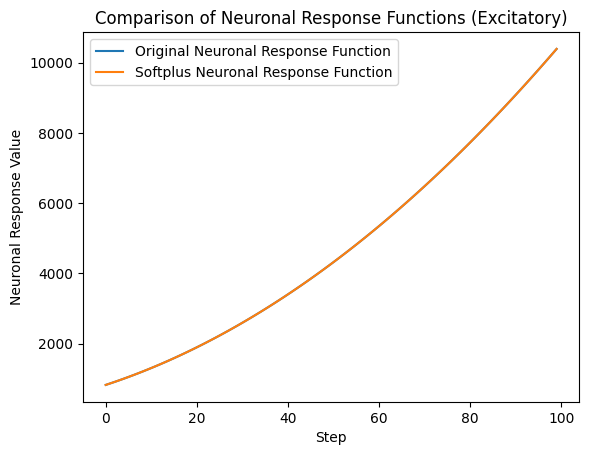

In [21]:
plt.plot(normal_calcs, label="Original Neuronal Response Function")
plt.plot(softplus_calcs, label="Softplus Neuronal Response Function")
plt.legend()

plt.title('Comparison of Neuronal Response Functions (Excitatory)')
plt.xlabel('Step')
plt.ylabel('Neuronal Response Value')

plt.show()

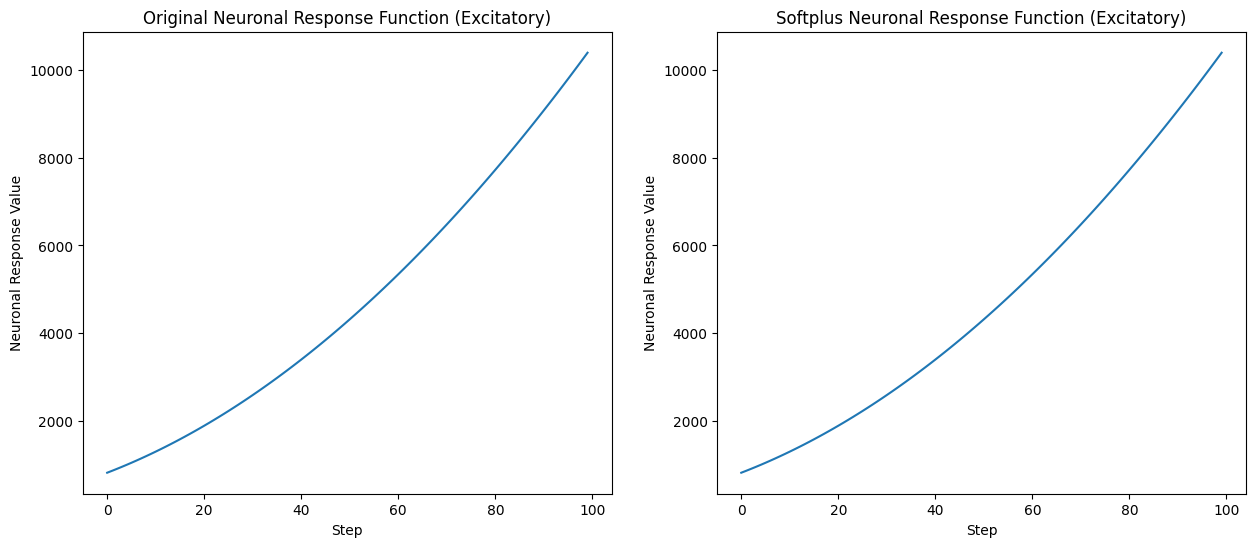

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(normal_calcs, label="Original")
ax[0].set_title('Original Neuronal Response Function (Excitatory)')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Neuronal Response Value')
# ax[0].legend()

ax[1].plot(softplus_calcs, label="Softplus")
ax[1].set_title('Softplus Neuronal Response Function (Excitatory)')
ax[1].set_xlabel('Step')
ax[1].set_ylabel('Neuronal Response Value')
# ax[1].legend()

plt.show()

## Simulating the RWW Model using the different calculation methods

In [2]:
sc = np.genfromtxt('../data/DTI_fiber_consensus_HCP.csv', delimiter=',')

fc = loadmat('../data/sub-ADNI002S0413_ses-M084_task-rest_space-MNI152Lin_res-2_desc-preproc_bold_ExtSchaefer116_ROI_activity.mat')
fc = fc['ROI_activity'][:100, :]

fc = (fc - fc.mean(axis=0)) / fc.std(axis=0)
fc = fc.T
fc = np.corrcoef(fc.T)

In [3]:
node_size = 100
mask = np.tril_indices(node_size, -1)
num_epochs = 50
TPperWindow = 20
step_size = 0.1
input_size = 2
tr = 0.75
repeat_size = 5
ts_length = fc.shape[0]

SC = (sc + sc.T) * 0.5
sc = np.log1p(SC) / np.linalg.norm(np.log1p(SC))

In [4]:
# params = ParamsRWWABT(bAB_E=par(val=0.7, fit_par=True), sAB_E=par(val=1.7, fit_par=True), bt_E=par(val=-0.5, fit_par=True),
#                       st_E=par(val=-2.8, fit_par=True), bAB_I=par(val=0.3, fit_par=True), sAB_I=par(val=-3.1, fit_par=True))

params = ParamsRWWABT(bAB_E=par(val=0), sAB_E=par(val=0), bt_E=par(val=0),
                      st_E=par(val=0), bAB_I=par(val=0), sAB_I=par(val=0))

abeta_file = np.genfromtxt(f'../data/avg_scans/AB_CN.csv', delimiter=",")
abeta = torch.tensor(abeta_file, dtype=torch.float32)

tau_file = np.genfromtxt(f'../data/avg_scans/TAU_CN.csv', delimiter=",")
tau = torch.tensor(tau_file, dtype=torch.float32)

model = RNNRWWABT(node_size, TPperWindow, step_size, repeat_size, tr, sc, abeta, tau, use_fit_gains=True, params=params)

# create objective function
ObjFun = CostsRWW(model)

# call model fit
F = Model_fitting(model, ObjFun)

In [5]:
# Model Training
# ---------------------------------------------------
#
F.train(u = 0, empFcs = [torch.from_numpy(fc)], num_epochs = num_epochs, num_windows = int(ts_length / TPperWindow), learningrate = 0.1, early_stopping=True)

epoch:  0 Pseudo FC_cor:  0.05944891712861401
loss: 15.931709766357972
epoch:  1 Pseudo FC_cor:  0.05120895138603316
loss: 12.386012971589812
epoch:  2 Pseudo FC_cor:  0.055934898804087745
loss: 10.442280799749161
epoch:  3 Pseudo FC_cor:  0.07180994522020966
loss: 9.71871494533324
epoch:  4 Pseudo FC_cor:  0.055491031484575966
loss: 9.682932686566597
epoch:  5 Pseudo FC_cor:  0.07550183895391015
loss: 9.852603719797333
epoch:  6 Pseudo FC_cor:  0.09935010242574395
loss: 9.525443941582074
epoch:  7 Pseudo FC_cor:  0.08678407860601323
loss: 9.649084371291133
epoch:  8 Pseudo FC_cor:  0.11766984078500356
loss: 9.54399327382177
epoch:  9 Pseudo FC_cor:  0.16922115189328538
loss: 9.226267924621592
epoch:  10 Pseudo FC_cor:  0.14739705972049472
loss: 9.322032570030293
epoch:  11 Pseudo FC_cor:  0.14482459548996868
loss: 9.515858433205333
epoch:  12 Pseudo FC_cor:  0.21392264565241365
loss: 9.168103915599065
epoch:  13 Pseudo FC_cor:  0.1682147646821818
loss: 9.226543550084907
epoch:  14 Pse

In [6]:
# normal_dmf = np.array(F.trainingStats.loss)
# np.save('normal_dmf_zeroes.npy', normal_dmf)
# softplus_dmf = np.array(F.trainingStats.loss)
# np.save('softplus_dmf_zeroes.npy', softplus_dmf)

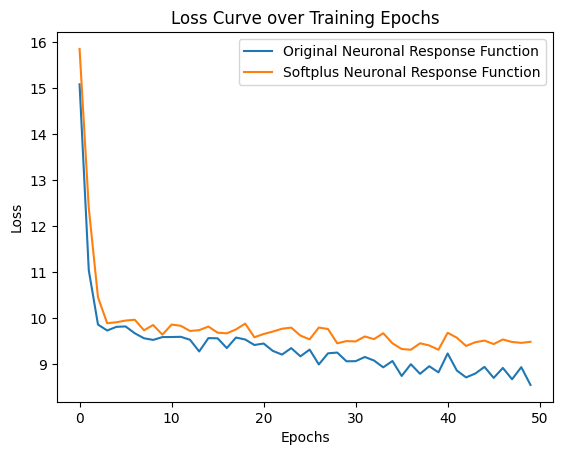

In [7]:
normal_dmf = np.load('normal_dmf.npy')
softplus_dmf = np.load('softplus_dmf.npy')

plt.plot(normal_dmf, label='Original Neuronal Response Function')
plt.plot(softplus_dmf, label='Softplus Neuronal Response Function')
plt.title('Loss Curve over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()